In [2]:
from sqlalchemy import create_engine, text
import pandas as pd
from ml_experiments.analyze import get_df_runs_from_mlflow_sql, get_missing_entries, get_common_combinations, get_df_with_combinations
import plotly.express as px
from itertools import product
import time
import numpy as np
import seaborn as sns

# Save Results

## Load mlflow runs

In [ ]:
db_port = 5003
db_name = 'recursive_clustering'
w = 'clust9'
# url = f'postgresql://{w}.ceremade.dauphine.lan:{db_port}/{db_name}'
url = f'postgresql://belucci@localhost:{db_port}/{db_name}'
engine = create_engine(url)
query = 'SELECT experiments.name from experiments'
experiment_names = pd.read_sql(query, engine)['name'].tolist()
# results_dir = Path('~/tab_benchmark/results')
# os.makedirs(results_dir, exist_ok=True)

In [4]:
experiment_names

['Default',
 'blob_experiment',
 'hpo_classif_experiment',
 'hpo_openml_experiment',
 'hpo_gaussian_experiment']

In [5]:
experiments_names = [
    'hpo_gaussian_experiment',
]

In [6]:
params_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'n_centers',
    'distance',
    'seed_unified',
]

In [7]:
latest_metrics_columns = [
    'fit_model_return_elapsed_time',
    'max_memory_used',
    'n_clusters_',
    'rand_score',
    'adjusted_rand',
    'mutual_info',
    'adjusted_mutual_info',
    'normalized_mutual_info',
    'homogeneity_completeness_v_measure',
    'silhouette',
    'best_n_clusters_',
    'best_rand_score',
    'best_adjusted_rand',
    'best_mutual_info',
    'best_adjusted_mutual_info',
    'best_normalized_mutual_info',
    'best_homogeneity_completeness_v_measure',
    'best_silhouette',
]

In [8]:
tags_columns = [
    'raised_exception',
    'EXCEPTION',
    'parent_run_id',
    'best_child_run_id',
]

In [9]:
runs_columns = ['run_uuid', 'status', 'start_time', 'end_time']
experiments_columns = []
other_table = 'params'
other_table_keys = params_columns
df_params = get_df_runs_from_mlflow_sql(engine, runs_columns=runs_columns, experiments_columns=experiments_columns, experiments_names=experiments_names, other_table=other_table, other_table_keys=other_table_keys)
df_latest_metrics = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='latest_metrics', other_table_keys=latest_metrics_columns)
df_tags = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='tags', other_table_keys=tags_columns)

In [10]:
df_runs_raw = df_params.join(df_latest_metrics)
df_runs_raw = df_runs_raw.join(df_tags)

In [11]:
df_runs_raw_parents = df_runs_raw.copy()
df_runs_raw_parents = df_runs_raw_parents.loc[df_runs_raw_parents['parent_run_id'].isna()]

In [12]:
df_runs_raw_parents

key,status,start_time,end_time,distance,model_nickname,n_centers,n_features,n_samples,seed_unified,adjusted_mutual_info,...,max_memory_used,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
00d72239d3d442cd92f198f39d180401,FINISHED,1737417765262,1.737418e+12,5.0,AffinityPropagation,5,1000,100,1,0.052337,...,349.024,0.217890,24.0,0.092974,0.776361,-0.003887,NaN,9cf265ec6b0042ef9f98cf013f584ca6,NaN,False
00f5ede9d1d3460580e6ec22c4e2010d,FINISHED,1737370049357,1.737370e+12,100.0,HDBSCAN,5,100,1000,3,1.000000,...,525.568,1.609438,5.0,1.000000,1.000000,0.859418,NaN,d120a6fecc2b4a8ba19678a96dd5caac,NaN,False
01435afcd6fb481b966e4c91c37a7929,FINISHED,1737370014728,1.737370e+12,30.0,WardAgglomerativeClustering,5,100,1000,5,0.769025,...,516.412,1.609438,14.0,0.769601,0.880928,0.002602,NaN,6305eb488d744b84ba80edcdf108f443,NaN,False
0146e2f7bcde414c89652abf655baa8c,FINISHED,1737417830446,1.737418e+12,30.0,WardAgglomerativeClustering,5,1000,1000,0,0.771151,...,549.276,1.609438,14.0,0.771724,0.882679,0.000147,NaN,5dd2c7a93fb844a3a83ac6609128ffa0,NaN,False
017138d5d2e345ad9ae7558e02e6ba68,FINISHED,1737370025437,1.737403e+12,3.0,SpectralSubspaceRandomization,5,100,1000,6,0.139336,...,16105.284,0.341715,30.0,0.143582,0.790122,-0.009516,NaN,0bc87d170a7c4c219e57450cfd8abfb4,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fee797330cdd473db838f3b87d418f78,FINISHED,1737370077969,1.737400e+12,5.0,AffinityPropagation,5,100,1000,9,0.275843,...,1432.916,0.953065,162.0,0.290882,0.802651,-0.010245,NaN,9deb4c2278d440e6bfe9327a8420f8ff,NaN,False
fef66750ca9c4469a783662c957b3eb8,FINISHED,1737417802981,1.737419e+12,10.0,WardAgglomerativeClustering,5,1000,1000,3,0.712519,...,576.268,1.492547,14.0,0.713236,0.873611,-0.000762,NaN,40fffeb15abe4c52a0ccd56613b9ca5d,NaN,False
fefa886e7787483a994a7774c47b50ce,FINISHED,1737417746438,1.737423e+12,3.0,AffinityPropagation,5,1000,1000,4,0.007942,...,1359.220,0.079953,133.0,0.025368,0.793431,-0.027983,NaN,e4b33d8ac5dc4a1084e91ffa92a96675,NaN,False


## Delete duplicate runs (if any) and complete some models that cannot run with some datasets

In [13]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'n_centers',
    'distance',
    'seed_unified',
]
df_runs_parents = df_runs_raw_parents.dropna(axis=0, how='all', subset=['best_adjusted_rand']).copy()
df_runs_parents = df_runs_parents.loc[(~df_runs_parents.duplicated(non_duplicate_columns))]

no_run_time = 4*3600
df_runs_timed_out = df_runs_raw.copy()
df_runs_timed_out = df_runs_timed_out.loc[df_runs_timed_out.EXCEPTION == 'FunctionTimedOut']
df_runs_timed_out = df_runs_timed_out.loc[(~df_runs_timed_out.duplicated(non_duplicate_columns))]
df_runs_timed_out['fit_model_return_elapsed_time'] = no_run_time
df_runs = pd.concat([df_runs, df_runs_timed_out])

status = 'FAILED'
no_run_memory = 2*120000
raised_exception = True
EXCEPTION = 'NoRun'
start_time = time.time() * 1000
end_time = time.time() * 1000

# IRFLLRR do not run with n_samples > 14427
model_nickname = 'IRFLLRR'
n_samples = ['14427', '50000']
n_features = ['100', '347', '1202', '4163', '14427', '50000']
combinations = product(n_samples, n_features)
df_cat = []
indexes = []
for n_sample, n_feature in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs = pd.concat([df_runs, df_no_run])

# KMeansProj do not run with (14427,14427), (14427,50000), (50000,14427), (50000,50000)
model_nickname = 'KMeansProj'
n_samples = ['14427', '50000']
n_features = ['14427', '50000']
combinations = product(n_samples, n_features)
df_cat = []
indexes = []
for n_sample, n_feature in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs = pd.concat([df_runs, df_no_run])

# HDBSCAN do not run with (14427,14427), (14427,50000), and n_samples = 50000 n_features > 347
model_nickname = 'HDBSCAN'
n_samples = ['50000']
n_features = ['347', '1202', '4163', '14427', '50000']
combinations = list(product(n_samples, n_features))
combinations += [('14427', '14427'), ('14427', '50000')]
df_cat = []
indexes = []
for n_sample, n_feature in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs = pd.concat([df_runs, df_no_run])

# SpectralSubspaceRandomization do not run with n_samples > 50000
model_nickname = 'SpectralSubspaceRandomization'
n_samples = ['50000']
n_features = ['100', '347', '1202', '4163', '14427', '50000']
combinations = list(product(n_samples, n_features))
df_cat = []
indexes = []
for n_sample, n_feature in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs = pd.concat([df_runs, df_no_run])

# ensure no duplicates
df_runs = df_runs.loc[(~df_runs.duplicated(non_duplicate_columns))]

# Missing

In [14]:
df_runs_parents['model_nickname'].unique().tolist()

['AffinityPropagation',
 'HDBSCAN',
 'WardAgglomerativeClustering',
 'SpectralSubspaceRandomization',
 'RecursiveClustering',
 'KMeans',
 'DBSCAN']

In [15]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'distance',
    'n_centers',
    'seed_unified',
]

In [18]:
n_samples = ['100', '1000']
n_features = ['1000']
distances = ['3.0', '5.0', '10.0', '30.0', '100.0']
n_centers = ['5']
seed_unified = [f'{i}' for i in range(5)]
model_nickname = [
    'AffinityPropagation',
    'HDBSCAN',
    'WardAgglomerativeClustering',
    'SpectralSubspaceRandomization',
    'RecursiveClustering',
    'KMeans',
    'DBSCAN'
]
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, n_features, distances, n_centers, seed_unified]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)

In [20]:
df_missing

,model_nickname,n_samples,n_features,distance,n_centers,seed_unified
0,SpectralSubspaceRandomization,1000,1000,30.0,5,4
1,SpectralSubspaceRandomization,1000,1000,100.0,5,4


# Get common combinations

In [21]:
model_nickname = [
    'AffinityPropagation',
    'HDBSCAN',
    'WardAgglomerativeClustering',
    'SpectralSubspaceRandomization',
    'RecursiveClustering',
    'KMeans',
    'DBSCAN'
]
df = df_runs_parents.copy()
df = df.loc[df['model_nickname'].isin(model_nickname)]
column = 'model_nickname'
combination_columns = [
    'n_samples',
    'n_features',
    'distance',
    'n_centers',
    'seed_unified',
]
common_combinations = get_common_combinations(df, column, combination_columns)

In [22]:
df_common = get_df_with_combinations(df, combination_columns, common_combinations)

In [23]:
df_common['n_samples'] = df_common['n_samples'].astype(int)
df_common['n_features'] = df_common['n_features'].astype(int)
df_common['distance'] = df_common['distance'].astype(float)
df_common['n_centers'] = df_common['n_centers'].astype(float)
df_common['seed_unified'] = df_common['seed_unified'].astype(int)

In [24]:
df_common

key,status,start_time,end_time,distance,model_nickname,n_centers,n_features,n_samples,seed_unified,adjusted_mutual_info,...,max_memory_used,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
00d72239d3d442cd92f198f39d180401,FINISHED,1737417765262,1.737418e+12,5.0,AffinityPropagation,5.0,1000,100,1,0.052337,...,349.024,0.217890,24.0,0.092974,0.776361,-0.003887,NaN,9cf265ec6b0042ef9f98cf013f584ca6,NaN,False
00f5ede9d1d3460580e6ec22c4e2010d,FINISHED,1737370049357,1.737370e+12,100.0,HDBSCAN,5.0,100,1000,3,1.000000,...,525.568,1.609438,5.0,1.000000,1.000000,0.859418,NaN,d120a6fecc2b4a8ba19678a96dd5caac,NaN,False
01435afcd6fb481b966e4c91c37a7929,FINISHED,1737370014728,1.737370e+12,30.0,WardAgglomerativeClustering,5.0,100,1000,5,0.769025,...,516.412,1.609438,14.0,0.769601,0.880928,0.002602,NaN,6305eb488d744b84ba80edcdf108f443,NaN,False
0146e2f7bcde414c89652abf655baa8c,FINISHED,1737417830446,1.737418e+12,30.0,WardAgglomerativeClustering,5.0,1000,1000,0,0.771151,...,549.276,1.609438,14.0,0.771724,0.882679,0.000147,NaN,5dd2c7a93fb844a3a83ac6609128ffa0,NaN,False
017138d5d2e345ad9ae7558e02e6ba68,FINISHED,1737370025437,1.737403e+12,3.0,SpectralSubspaceRandomization,5.0,100,1000,6,0.139336,...,16105.284,0.341715,30.0,0.143582,0.790122,-0.009516,NaN,0bc87d170a7c4c219e57450cfd8abfb4,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fee797330cdd473db838f3b87d418f78,FINISHED,1737370077969,1.737400e+12,5.0,AffinityPropagation,5.0,100,1000,9,0.275843,...,1432.916,0.953065,162.0,0.290882,0.802651,-0.010245,NaN,9deb4c2278d440e6bfe9327a8420f8ff,NaN,False
fef66750ca9c4469a783662c957b3eb8,FINISHED,1737417802981,1.737419e+12,10.0,WardAgglomerativeClustering,5.0,1000,1000,3,0.712519,...,576.268,1.492547,14.0,0.713236,0.873611,-0.000762,NaN,40fffeb15abe4c52a0ccd56613b9ca5d,NaN,False
fefa886e7787483a994a7774c47b50ce,FINISHED,1737417746438,1.737423e+12,3.0,AffinityPropagation,5.0,1000,1000,4,0.007942,...,1359.220,0.079953,133.0,0.025368,0.793431,-0.027983,NaN,e4b33d8ac5dc4a1084e91ffa92a96675,NaN,False


# Plots

In [1]:
df = df_common.copy()
df = df.loc[df['n_samples'] == 1000]
df = df.loc[df['n_features'] == 100]
df = df.loc[df['n_centers'] == 5.0]
df = df.sort_values(['model_nickname', 'distance'])
fig = px.line(df, x='distance', y='best_adjusted_rand', color='model_nickname', line_group='seed_unified')
fig.show()
sns.relplot(data=df, x='distance', y='best_adjusted_rand', hue='model_nickname', kind='line', errorbar='ci')

NameError: name 'df_common' is not defined

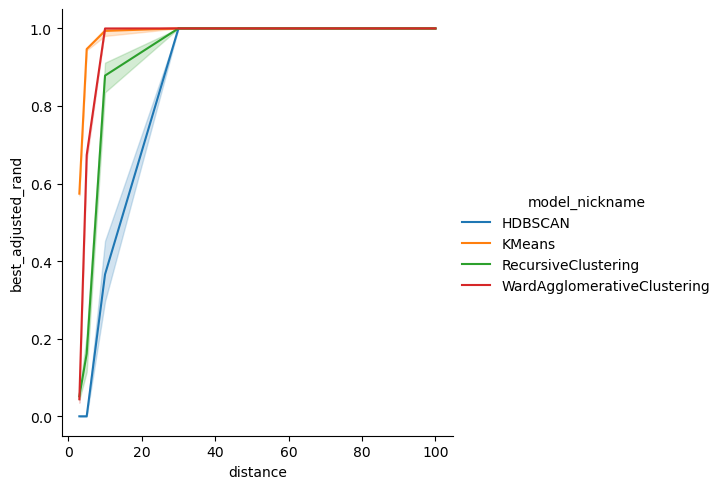

In [125]:
df = df_common.copy()
df = df.loc[df['n_samples'] == 1000]
df = df.loc[df['n_features'] == 1000]
df = df.loc[df['pct_random'] == 0.5]
df = df.loc[df['class_sep'] == 100.0]
df = df.sort_values('model_nickname')
fig = px.box(df, x='model_nickname', y='best_adjusted_rand', color='model_nickname')
fig.show()

In [126]:
df = df_common.copy()
df = df.loc[df['n_samples'] == 1000]
df = df.loc[df['n_features'] == 1000]
# df = df.loc[df['pct_random'] == 0.7]
df = df.loc[df['class_sep'] == 100.0]
df = df.loc[df['model_nickname'].isin(['RecursiveClustering', 'KMeans', 'HDBSCAN', 'DBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df = df.sort_values('model_nickname')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_features': 'Number of features', 'model_nickname': 'Model', 'best_adjusted_rand': 'Adjusted Rand', 'best_n_clusters_': 'Number of Clusters Found', 'n_classes': 'True Number of Clusters', 'class_sep': 'Class Separation', 'pct_random': '% Random Features', 'seed_unified': 'Seed'})
df = df[['Model', 'Adjusted Rand', 'Time (s)', 'Memory (MB)', 'Number of samples', 'Number of features', 'Class Separation', '% Random Features', 'Seed', 'Number of Clusters Found', 'True Number of Clusters']]
df = df.groupby('Model').agg({'Adjusted Rand': ['mean', 'std'], 'Number of Clusters Found': ['median', ('Q25', lambda x: x.quantile(0.25)), ('Q75', lambda x: x.quantile(0.75))], 'Time (s)': ['mean', 'std'], 'Memory (MB)': ['mean', 'std'], 'Number of samples': ['mean', 'nunique'], 'Number of features': ['mean', 'nunique'], 'Class Separation': ['mean', 'nunique'], '% Random Features': ['mean', 'nunique'], 'True Number of Clusters': ['mean', 'nunique'], 'Seed': ['mean', 'nunique']})
df.to_csv('simulated_data_easy.csv')
df

key                           Adjusted Rand      Number of Clusters Found  \
                                       mean  std                   median   
Model                                                                       
AffinityPropagation                     1.0  0.0                      5.0   
DBSCAN                                  0.0  0.0                      1.0   
HDBSCAN                                 1.0  0.0                      5.0   
KMeans                                  1.0  0.0                      5.0   
OPTICS                                  1.0  0.0                      5.0   
RecursiveClustering                     1.0  0.0                      5.0   
SpectralSubspaceRandomization           1.0  0.0                      5.0   
WardAgglomerativeClustering             1.0  0.0                      5.0   

key                                         Time (s)             Memory (MB)  \
                               Q25  Q75         mean         std        mean   
Model                                                                          
AffinityPropagation            5.0  5.0   537.226421   39.111352   2059.4429   
DBSCAN                         1.0  1.0   495.724737   24.503844   2034.5569   
HDBSCAN                        5.0  5.0   156.379071   16.678345   1951.1594   
KMeans                         5.0  5.0   455.211977   39.756185   2024.6738   
OPTICS                         5.0  5.0   186.481377   12.323363   2067.3815   
RecursiveClustering            5.0  5.0  2264.785293  217.413369   2080.0290   
SpectralSubspaceRandomization  5.0  5.0  3496.919557  733.693875   1108.6247   
WardAgglomerativeClustering    5.0  5.0   267.337123   30.720733   2059.1330   

key                                       Number of samples  ...  \
                                      std              mean  ...   
Model                                                        ...   
AffinityPropagation              1.779558            1000.0  ...   
DBSCAN                           1.282687            1000.0  ...   
HDBSCAN                        228.016285            1000.0  ...   
KMeans                         151.542389            1000.0  ...   
OPTICS                           0.839997            1000.0  ...   
RecursiveClustering              2.354198            1000.0  ...   
SpectralSubspaceRandomization   27.026635            1000.0  ...   
WardAgglomerativeClustering      1.695819            1000.0  ...   

key                           Number of features         Class Separation  \
                                            mean nunique             mean   
Model                                                                       
AffinityPropagation                       1000.0       1            100.0   
DBSCAN                                    1000.0       1            100.0   
HDBSCAN                                   1000.0       1            100.0   
KMeans                                    1000.0       1            100.0   
OPTICS                                    1000.0       1            100.0   
RecursiveClustering                       1000.0       1            100.0   
SpectralSubspaceRandomization             1000.0       1            100.0   
WardAgglomerativeClustering               1000.0       1            100.0   

key                                   % Random Features          \
                              nunique              mean nunique   
Model                                                             
AffinityPropagation                 1              0.35       4   
DBSCAN                              1              0.35       4   
HDBSCAN                             1              0.35       4   
KMeans                              1              0.35       4   
OPTICS                              1              0.35       4   
RecursiveClustering                 1              0.35       4   
SpectralSubspaceRandomization       1              0.35       4   
Ward

In [127]:
df = df_common.copy()
df = df.loc[df['n_samples'] == 1000]
df = df.loc[df['n_features'] == 1000]
df = df.loc[df['pct_random'] == 0.5]
df = df.loc[df['class_sep'] == 10.0]
df = df.loc[df['model_nickname'].isin(['RecursiveClustering', 'KMeans', 'HDBSCAN', 'DBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df = df.sort_values('model_nickname')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_features': 'Number of features', 'model_nickname': 'Model', 'best_adjusted_rand': 'Adjusted Rand', 'best_n_clusters_': 'Number of Clusters Found', 'n_classes': 'True Number of Clusters', 'class_sep': 'Class Separation', 'pct_random': '% Random Features', 'seed_unified': 'Seed'})
df = df[['Model', 'Adjusted Rand', 'Time (s)', 'Memory (MB)', 'Number of samples', 'Number of features', 'Class Separation', '% Random Features', 'Seed', 'Number of Clusters Found', 'True Number of Clusters']]
df = df.groupby('Model').agg({'Adjusted Rand': ['mean', 'std'], 'Number of Clusters Found': ['median', ('Q25', lambda x: x.quantile(0.25)), ('Q75', lambda x: x.quantile(0.75))], 'Time (s)': ['mean', 'std'], 'Memory (MB)': ['mean', 'std'], 'Number of samples': ['mean', 'nunique'], 'Number of features': ['mean', 'nunique'], 'Class Separation': ['mean', 'nunique'], '% Random Features': ['mean', 'nunique'], 'True Number of Clusters': ['mean', 'nunique'], 'Seed': ['mean', 'nunique']})
df.to_csv('simulated_data_hard.csv')
df

key                           Adjusted Rand            \
                                       mean       std   
Model                                                   
AffinityPropagation                0.189093  0.017298   
DBSCAN                             0.000000  0.000000   
HDBSCAN                            0.993713  0.003036   
KMeans                             0.200988  0.060978   
OPTICS                             0.399327  0.344323   
RecursiveClustering                0.433655  0.230195   
SpectralSubspaceRandomization      0.915287  0.202475   
WardAgglomerativeClustering        0.494884  0.296377   

key                           Number of Clusters Found              \
                                                median  Q25    Q75   
Model                                                                
AffinityPropagation                               21.5  2.0  42.00   
DBSCAN                                             1.0  1.0   1.00   
HDBSCAN                                            6.0  6.0   6.00   
KMeans                                             2.0  2.0   2.00   
OPTICS                                             2.5  2.0   4.50   
RecursiveClustering                                4.0  3.0   4.75   
SpectralSubspaceRandomization                      5.0  5.0   5.00   
WardAgglomerativeClustering                        2.0  2.0   4.25   

key                               Time (s)             Memory (MB)  \
                                      mean         std        mean   
Model                                                                
AffinityPropagation             529.730182   10.693666   2059.4900   
DBSCAN                          478.425069    8.144741   2034.9944   
HDBSCAN                         157.498777    5.076115   2008.3772   
KMeans                          421.863799   23.231615   2065.8152   
OPTICS                          193.670200    4.669891   2067.3468   
RecursiveClustering            2390.756949  168.434082   2078.1840   
SpectralSubspaceRandomization  3650.157271  473.980725   1103.1100   
WardAgglomerativeClustering     250.402186   13.845500   2058.1964   

key                                       Number of samples  ...  \
                                      std              mean  ...   
Model                                                        ...   
AffinityPropagation              2.024502            1000.0  ...   
DBSCAN                           1.190787            1000.0  ...   
HDBSCAN                        178.319054            1000.0  ...   
KMeans                           4.504178            1000.0  ...   
OPTICS                           1.081793            1000.0  ...   
RecursiveClustering              2.627123            1000.0  ...   
SpectralSubspaceRandomization    4.184572            1000.0  ...   
WardAgglomerativeClustering      2.105722            1000.0  ...   

key                           Number of features         Class Separation  \
                                            mean nunique             mean   
Model                                                                       
AffinityPropagation                       1000.0       1             10.0   
DBSCAN                                    1000.0       1             10.0   
HDBSCAN                                   1000.0       1             10.0   
KMeans                                    1000.0       1             10.0   
OPTICS                                    1000.0       1             10.0   
RecursiveClustering                       1000.0       1             10.0   
SpectralSubspaceRandomization             1000.0       1             10.0   
WardAgglomerativeClustering               1000.0       1             10.0   

key                                   % Random Features          \
                              nunique              mean nunique   
Model                                                             
AffinityPropagation             

# With filling values

In [128]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'pct_random',
    'seed_unified',
    'class_sep',
    'n_random',
    'n_informative',
    'n_classes'
]
df_runs_parents_fill = df_runs_raw_parents.dropna(axis=0, how='all', subset=['best_adjusted_rand']).copy()
df_runs_parents_fill = df_runs_parents_fill.loc[(~df_runs_parents_fill.duplicated(non_duplicate_columns))]

In [129]:
# for the moment, I did not manage to run HDBSCAN and SpectralSubspaceRandomization with samples >= 10000, so we will fill these values for the moment as "no run" and we will see later
status = 'FAILED'
no_run_time = np.inf
no_run_memory = np.inf
no_run_metric = np.nan
raised_exception = True
EXCEPTION = 'NoRun'
start_time = time.time() * 1000
end_time = time.time() * 1000

In [130]:
model_nickname = 'HDBSCAN'
n_samples = ['10000']
n_features = ['100', '1000', '10000']
pct_random = ['0.0', '0.2', '0.5', '0.7']
seed_unified = [f'{i}' for i in range(10)]
class_sep = ['10.0', '100.0', '50.0']
n_classes = 5
combinations = list(product(n_samples, n_features, pct_random, seed_unified, class_sep))
df_cat = []
indexes = []
for n_sample, n_feature, pct_r, seed, class_s in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_classes'] = n_classes
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['pct_random'] = pct_r
    df['seed_unified'] = seed
    df['class_sep'] = class_s
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['best_adjusted_rand'] = no_run_metric
    df['best_n_clusters_'] = no_run_metric
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs_parents_fill = pd.concat([df_runs_parents_fill, df_no_run])

In [131]:
model_nickname = 'SpectralSubspaceRandomization'
n_samples = ['10000']
n_features = ['100', '1000', '10000']
pct_random = ['0.0', '0.2', '0.5', '0.7']
seed_unified = [f'{i}' for i in range(10)]
class_sep = ['10.0', '100.0', '50.0']
n_classes = 5
combinations = list(product(n_samples, n_features, pct_random, seed_unified, class_sep))
df_cat = []
indexes = []
for n_sample, n_feature, pct_r, seed, class_s in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_classes'] = n_classes
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['pct_random'] = pct_r
    df['seed_unified'] = seed
    df['class_sep'] = class_s
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['best_adjusted_rand'] = no_run_metric
    df['best_n_clusters_'] = no_run_metric
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs_parents_fill = pd.concat([df_runs_parents_fill, df_no_run])

In [132]:
# ensure no duplicates
df_runs_parents_fill = df_runs_parents_fill.loc[(~df_runs_parents_fill.duplicated(non_duplicate_columns))]

# Missing

In [133]:
df_runs_parents_fill['model_nickname'].unique().tolist()

['AffinityPropagation',
 'RecursiveClustering',
 'AverageAgglomerativeClustering',
 'HDBSCAN',
 'DBSCAN',
 'KMeansProj',
 'OPTICS',
 'SpectralSubspaceRandomization',
 'Proclus',
 'WardAgglomerativeClustering',
 'KMeans',
 'SingleAgglomerativeClustering',
 'SpectralClustering',
 'CompleteAgglomerativeClustering',
 'IRFLLRR',
 'Clique']

In [134]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'pct_random',
    'seed_unified',
    'class_sep',
]

In [135]:
df_runs_parents_fill

,status,start_time,end_time,class_sep,model_nickname,n_classes,n_features,n_informative,n_random,n_samples,...,max_memory_used,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
000aaf76d56747d59a35d53ba0fde4a4,FINISHED,1.736981e+12,1.736985e+12,50.0,AffinityPropagation,5,10000,2,16,100,...,2000.884,1.609438,10.0,0.837703,0.912525,0.165996,NaN,20b7f8404daf40f0b2c5d0bd9f3730db,NaN,False
000b291a142341289479933ddb447488,FINISHED,1.736872e+12,1.736877e+12,50.0,RecursiveClustering,5,10000,2,16,1000,...,1156.568,1.609438,577.0,0.425927,0.806024,-0.104928,NaN,e62023cb27d941dd8b9683eaef947ccc,NaN,False
000f29a52641434a9a03ec3951ba12ba,FINISHED,1.736890e+12,1.736911e+12,50.0,AverageAgglomerativeClustering,5,10000,2,16,10000,...,1941.040,1.608578,8.0,0.997419,0.999561,0.283838,NaN,8e0a1045c9474ca5925d553aa6030f20,NaN,False
00142f7d57c244c2b33da0cfa8480cbf,FINISHED,1.737110e+12,1.737119e+12,50.0,HDBSCAN,5,10000,2,16,100,...,1982.980,1.609438,5.0,1.000000,1.000000,0.410559,NaN,3196639866e543c0beba6df8434456b6,NaN,False
00151ab7956742b391a46ebbc769a9ff,FINISHED,1.737069e+12,1.737078e+12,50.0,DBSCAN,5,100,2,16,10000,...,1611.760,1.606954,6.0,0.995135,0.999239,0.906276,NaN,830e0db68eb041c1b24fe960ac07e499,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SpectralSubspaceRandomization_10000_10000,FAILED,1.737132e+12,1.737132e+12,100.0,SpectralSubspaceRandomization,5,10000,NaN,NaN,10000,...,inf,NaN,NaN,NaN,NaN,NaN,NoRun,NaN,NaN,True
SpectralSubspaceRandomization_10000_10000,FAILED,1.737132e+12,1.737132e+12,50.0,SpectralSubspaceRandomization,5,10000,NaN,NaN,10000,...,inf,NaN,NaN,NaN,NaN,NaN,NoRun,NaN,NaN,True
SpectralSubspaceRandomization_10000_10000,FAILED,1.737132e+12,1.737132e+12,10.0,SpectralSubspaceRandomization,5,10000,NaN,NaN,10000,...,inf,NaN,NaN,NaN,NaN,NaN,NoRun,NaN,NaN,True
SpectralSubspaceRandomization_10000_10000,FAILED,1.737132e+12,1.737132e+12,100.0,SpectralSubspaceRandomization,5,10000,NaN,NaN,10000,...,inf,NaN,NaN,NaN,NaN,NaN,NoRun,NaN,NaN,True


In [136]:
n_samples = ['100', '1000', '10000']
n_features = ['100', '1000', '10000']
pct_random = ['0.0', '0.2', '0.5', '0.7']
seed_unified = [f'{i}' for i in range(1)]
class_sep = ['10.0', '100.0']
model_nickname = [
    # 'KMeansProj',
    # 'IRFLLRR',
    # 'Clique',
    'HDBSCAN',
    'SpectralSubspaceRandomization',
    'SingleAgglomerativeClustering',
    'SpectralClustering',
    'RecursiveClustering',
    'OPTICS',
    'Proclus',
    'WardAgglomerativeClustering',
    'KMeans',
    'DBSCAN',
    'CompleteAgglomerativeClustering',
    'AverageAgglomerativeClustering',
    'AffinityPropagation'
]
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, n_features, pct_random, seed_unified, class_sep]
df_missing = get_missing_entries(df_runs_parents_fill, columns_names, should_contain_values)

In [137]:
df_missing

,model_nickname,n_samples,n_features,pct_random,seed_unified,class_sep
0,SingleAgglomerativeClustering,10000,10000,0.0,0,10.0
1,SingleAgglomerativeClustering,10000,10000,0.0,0,100.0
2,SingleAgglomerativeClustering,10000,10000,0.2,0,10.0
3,SingleAgglomerativeClustering,10000,10000,0.2,0,100.0
4,SingleAgglomerativeClustering,10000,10000,0.5,0,10.0
5,SingleAgglomerativeClustering,10000,10000,0.5,0,100.0
6,SingleAgglomerativeClustering,10000,10000,0.7,0,10.0
7,SingleAgglomerativeClustering,10000,10000,0.7,0,100.0
8,SpectralClustering,10000,100,0.5,0,10.0
9,SpectralClustering,10000,100,0.5,0,100.0


# Get common combinations

In [138]:
model_nickname = [
    # 'KMeansProj',
    # 'IRFLLRR',
    # 'Clique',
    'HDBSCAN',
    'SpectralSubspaceRandomization',
    # 'SingleAgglomerativeClustering',
    # 'SpectralClustering',
    'RecursiveClustering',
    'OPTICS',
    'Proclus',
    'WardAgglomerativeClustering',
    'KMeans',
    'DBSCAN',
    'CompleteAgglomerativeClustering',
    'AverageAgglomerativeClustering',
    'AffinityPropagation'
]
df = df_runs_parents_fill.copy()
df = df.loc[df['model_nickname'].isin(model_nickname)]
column = 'model_nickname'
combination_columns = [
    'n_samples',
    'n_features',
    'pct_random',
    'seed_unified',
    'class_sep',
]
common_combinations = get_common_combinations(df, column, combination_columns)

In [139]:
df_common_fill = get_df_with_combinations(df, combination_columns, common_combinations)

In [140]:
df_common_fill['n_samples'] = df_common_fill['n_samples'].astype(int)
df_common_fill['n_features'] = df_common_fill['n_features'].astype(int)
df_common_fill['pct_random'] = df_common_fill['pct_random'].astype(float)
df_common_fill['class_sep'] = df_common_fill['class_sep'].astype(float)
df_common_fill['seed_unified'] = df_common_fill['seed_unified'].astype(int)
df_common_fill['n_classes'] = df_common_fill['n_classes'].astype(int)

## Plot

In [ ]:
df = df_common_fill.copy()
df = df.loc[df['n_samples'] == 10000]
df = df.loc[df['n_features'] == 10000]
# df = df.loc[df['pct_random'] == 0.5]
df = df.loc[df['class_sep'] == 50.0]
df = df.sort_values('model_nickname')
fig = px.box(df, x='model_nickname', y='best_adjusted_rand', color='model_nickname')
fig.show()

In [40]:
df = df_common_fill.copy()
df = df.loc[df['model_nickname'].isin(['RecursiveClustering', 'KMeans', 'HDBSCAN', 'DBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df['Config.'] = '\parbox{1.5cm}{l=' + df['class_sep'].astype(str) + '; n=' + df['n_samples'].astype(str) + '; p=' + df['n_features'].astype(str) + '; r=' + df['pct_random'].astype(str) + ';}'
df = df.rename(columns={'model_nickname': 'Model'})
df = df.groupby(['Config.', 'Model']).agg({'best_adjusted_rand': ['mean', 'std'], 'fit_model_return_elapsed_time': ['mean', 'std'], 'max_memory_used': ['mean', 'std'], 'seed_unified': 'count', 'class_sep': 'first', 'n_samples': 'first', 'n_features': 'first', 'pct_random': 'first'})
df = df.sort_values([('class_sep', 'first'), ('n_samples', 'first'), ('n_features', 'first'), ('pct_random', 'first')])
df = df[['best_adjusted_rand']]
df = df.rename(columns={'best_adjusted_rand': 'ARI'})
# df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_features': 'Number of features', 'model_nickname': 'Model', 'best_adjusted_rand': 'Adjusted Rand', 'best_n_clusters_': 'Number of Clusters Found', 'n_classes': 'True Number of Clusters', 'class_sep': 'Class Separation', 'pct_random': '% Random Features', 'seed_unified': 'Seed'})
# df = df[['Model', 'Adjusted Rand', 'Time (s)', 'Memory (MB)', 'Number of samples', 'Number of features', 'Class Separation', '% Random Features', 'Seed', 'Number of Clusters Found', 'True Number of Clusters']]
# df = df.groupby('Model').agg({'Adjusted Rand': ['mean', 'std'], 'Number of Clusters Found': ['median', ('Q25', lambda x: x.quantile(0.25)), ('Q75', lambda x: x.quantile(0.75))], 'Time (s)': ['mean', 'std'], 'Memory (MB)': ['mean', 'std'], 'Number of samples': ['mean', 'nunique'], 'Number of features': ['mean', 'nunique'], 'Class Separation': ['mean', 'nunique'], '% Random Features': ['mean', 'nunique'], 'True Number of Clusters': ['mean', 'nunique'], 'Seed': ['mean', 'nunique']})
# df.to_csv('simulated_data_easy_more_samples.csv')
# df

In [167]:
# "interesting cases"
# easy: 1000 samples, 1000 features, x random, 100 class sep
# easy more samples: 10000 samples, 10000 features, x random, 100 class sep
# hard: 1000 samples, 1000 features, x random, 10 class sep
# hard more samples: 10000 samples, 1000 features, x random, 10 class sep
# medium: x samples, 10000 features, x random, 50 class sep

df = df_common_fill.copy()
# df = df.loc[df['n_samples'] == 10000]
# df = df.loc[df['n_features'] == 10000]
# df = df.loc[df['pct_random'] == 0.5]
# df = df.loc[df['class_sep'] == 100.0]
df = df.loc[df['model_nickname'].isin(['RecursiveClustering', 'KMeans', 'HDBSCAN', 'DBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df['Config.'] = '\parbox{1.5cm}{l=' + df['class_sep'].astype(str) + '; n=' + df['n_samples'].astype(str) + '; p=' + df['n_features'].astype(str) + '; r=' + df['pct_random'].astype(str) + ';}'
df = df.rename(columns={'model_nickname': 'Model'})
df = df.groupby(['Config.', 'Model']).agg({'best_adjusted_rand': ['mean', 'std'], 'fit_model_return_elapsed_time': ['mean', 'std'], 'max_memory_used': ['mean', 'std'], 'seed_unified': 'count', 'class_sep': 'first', 'n_samples': 'first', 'n_features': 'first', 'pct_random': 'first'})
df = df.sort_values([('class_sep', 'first'), ('n_samples', 'first'), ('n_features', 'first'), ('pct_random', 'first')])
df = df.rename(columns={'best_adjusted_rand': 'ARI'})
# easy = 1000 samples, 1000 features, x random, 100 class sep
df_easy = df.loc[(df[('n_samples', 'first')] == 1000) & (df[('n_features', 'first')] == 1000) & (df[('class_sep', 'first')] == 100.0) 
                 & (df[('pct_random', 'first')] == 0.0)].copy()
df_easy = df_easy[['ARI']]
# easy more samples = 10000 samples, 10000 features, x random, 100 class sep
df_easy_more_samples = df.loc[(df[('n_samples', 'first')] == 10000) & (df[('n_features', 'first')] == 10000) & (df[('class_sep', 'first')] == 100.0)
                               & (df[('pct_random', 'first')] == 0.0)].copy()
df_easy_more_samples = df_easy_more_samples[['ARI']]
# hard = 1000 samples, 1000 features, x random, 10 class sep
df_hard = df.loc[(df[('n_samples', 'first')] == 1000) & (df[('n_features', 'first')] == 1000) & (df[('class_sep', 'first')] == 10.0)].copy()
df_hard = df_hard[['ARI']]
# hard more samples = 10000 samples, 1000 features, x random, 10 class sep
# df_hard_more_samples = df.loc[(df[('n_samples', 'first')] == 10000) & (df[('n_features', 'first')] == 1000) & (df[('class_sep', 'first')] == 10.0)].copy()
# df_hard_more_samples = df_hard_more_samples[['ARI']]
# medium = x samples, 10000 features, x random, 50 class sep
df_medium = df.loc[(df[('n_samples', 'first')] == 100) & (df[('n_features', 'first')] == 10000) & (df[('class_sep', 'first')] == 50.0) & (df[('pct_random', 'first')] == 0.0)].copy()
df_medium = df_medium[['ARI']]

df = pd.concat([df_easy, df_easy_more_samples, df_hard, df_medium], axis=0)

In [168]:
def highlight_max(df):
    max_values = df.groupby(level=0).transform('max')
    is_highlighted = df == max_values
    df_css = df.copy().astype(str)
    df_css.loc[:, :] = ''
    df_css[is_highlighted] = 'font-weight: bold'
    return df_css

In [169]:
print(df.style.apply(highlight_max, subset=[('ARI', 'mean')], axis=None).format(precision=3, na_rep='No Run').to_latex(hrules=True, clines='skip-last;data', convert_css=True))

\begin{tabular}{llrr}
\toprule
 &  & \multicolumn{2}{r}{ARI} \\
 &  & mean & std \\
Config. & Model &  &  \\
\midrule
\multirow[c]{8}{*}{\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}} & AffinityPropagation & \bfseries 1.000 & 0.000 \\
 & DBSCAN & 0.000 & 0.000 \\
 & HDBSCAN & \bfseries 1.000 & 0.000 \\
 & KMeans & \bfseries 1.000 & 0.000 \\
 & OPTICS & \bfseries 1.000 & 0.000 \\
 & RecursiveClustering & \bfseries 1.000 & 0.000 \\
 & SpectralSubspaceRandomization & \bfseries 1.000 & 0.000 \\
 & WardAgglomerativeClustering & \bfseries 1.000 & 0.000 \\
\cline{1-4}
\multirow[c]{8}{*}{\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;}} & AffinityPropagation & 0.115 & No Run \\
 & DBSCAN & 0.000 & No Run \\
 & HDBSCAN & No Run & No Run \\
 & KMeans & \bfseries 1.000 & No Run \\
 & OPTICS & \bfseries 1.000 & No Run \\
 & RecursiveClustering & \bfseries 1.000 & No Run \\
 & SpectralSubspaceRandomization & No Run & No Run \\
 & WardAgglomerativeClustering & 0.783 & No Run \\
\cline{1-4}
\multi

In [63]:
with pd.option_context('display.max_colwidth', None):
    display(df.style.highlight_max(subset=[('ARI', 'mean')], axis=0))

ARI  \
                                                                                                                                                            mean   
Config.                                           Model                                                                                                            
\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}   AffinityPropagation                     (\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}, AffinityPropagation)   
                                                  DBSCAN                                  (\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}, AffinityPropagation)   
                                                  HDBSCAN                                 (\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}, AffinityPropagation)   
                                                  KMeans                                  (\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}, AffinityPropagation)   
                                                  OPTICS                                  (\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}, AffinityPropagation)   
                                                  RecursiveClustering                     (\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}, AffinityPropagation)   
                                                  SpectralSubspaceRandomization           (\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}, AffinityPropagation)   
                                                  WardAgglomerativeClustering             (\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}, AffinityPropagation)   
\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;} AffinityPropagation                                (\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;}, KMeans)   
                                                  DBSCAN                                             (\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;}, KMeans)   
                                                  HDBSCAN                                            (\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;}, KMeans)   
                                                  KMeans                                             (\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;}, KMeans)   
                                                  OPTICS                                             (\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;}, KMeans)   
                                                  RecursiveClustering                                (\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;}, KMeans)   
                                                  SpectralSubspaceRandomization                      (\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;}, KMeans)   
                                                  WardAgglomerativeClustering                        (\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;}, KMeans)   
\parbox{1.5cm}{l=10.0; n=1000; p=1000; r=0.0;}    AffinityPropagation            (\parbox{1.5cm}{l=10.0; n=1000; p=1000; r=0.0;}, SpectralSubspaceRandomization)   
                                                  DBSCAN                         (\parbox{1.5cm}{l=10.0; n=1000; p=1000; r=0.0;}, SpectralSubspaceRandomization)   
                                                  HDBSCAN                        (\parbox{1.5cm}{l=10.0; n=1000; p=1000; r=0.0;}, SpectralSubspaceRandomization)   
                                                  KMeans                         (\parbox{1.5cm}{l=10.0; n=1000; p=1000; r=0.0;}, SpectralSubspaceRandomization)   
                                                  OPTICS                         (\parbox{1.5cm}{l=10.0; n=1000; p=1000; r=0.0;}, SpectralSubspaceRandomization)   
                                                  RecursiveClustering            (\parbox{1.5cm}{l=10.0; n=1000; p=1000; r=0.0;}, SpectralSubspaceRandomization)   
                                                  Spectra

# Debug and explore

In [61]:
df = df_runs_raw_parents.copy()
df = df.loc[df['model_nickname'] == 'SpectralClustering']
df = df.loc[df['n_samples'] == '10000']
df = df.loc[df['n_features'] == '100']
df = df.loc[df['best_adjusted_rand'].isna()]

In [62]:
df

key,status,start_time,end_time,class_sep,model_nickname,n_classes,n_features,n_informative,n_random,n_samples,...,max_memory_used,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
030506f367eb4de3ba20854815b5204e,RUNNING,1736933684597,NaN,50.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0a9621d4c0b94f71b8b3381c6fb5c007,RUNNING,1736933682412,NaN,50.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4283d0ec6c2a44609380a30ba9ad84b7,RUNNING,1736933676990,NaN,100.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86f54c66e3a24ae3abd719993b9e8e8f,RUNNING,1736933680295,NaN,10.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d40e99f19313471b849c6a89d5714ec3,RUNNING,1736933677012,NaN,10.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f2472d2177ee4224888a3f9221aa27f8,RUNNING,1736933676833,NaN,100.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
parent_run_ids = list(df.index)

In [39]:
parent_run_ids

['19a02df7b5aa4cf7afa3bd89746701e6',
 '49cd3a57c8c445888338d601be88e165',
 '4ca1b086e9d54eb69b43c9d2a9f61751',
 '8ebecbdcf2534dbdb37fab56eb920877',
 'bc25dc49e69644d9b4ea7d47831c0db5',
 'c08e53cf4d534e67904e72ae35794d0e']

In [40]:
df = df_runs_raw.copy()
df = df.loc[df['parent_run_id'].isin(parent_run_ids)]

In [41]:
child_run_ids = list(df.index)

In [42]:
runs_to_delete = parent_run_ids + child_run_ids

In [43]:
runs_to_delete

['19a02df7b5aa4cf7afa3bd89746701e6',
 '49cd3a57c8c445888338d601be88e165',
 '4ca1b086e9d54eb69b43c9d2a9f61751',
 '8ebecbdcf2534dbdb37fab56eb920877',
 'bc25dc49e69644d9b4ea7d47831c0db5',
 'c08e53cf4d534e67904e72ae35794d0e',
 '1d4c759e165b4267af1d71e2dadb662e',
 '4731af3b49f94df79ed9c06cb61e5da9',
 '667f300899fe4b998d839e3958dedbd0',
 '8f9e6a95c8bd4f838fcb3085a3927482',
 'c7b04bdc92654f8da5f28f7a0474de79',
 'e97b7dd9f4c94acb95ad1b389c91aa3d']

In [44]:
run_uuid_query = [f"'{run_id}'" for run_id in runs_to_delete]
run_uuid_query = ', '.join(run_uuid_query)

In [45]:
query = f"""
UPDATE runs
SET lifecycle_stage = 'deleted'
WHERE run_uuid IN ({run_uuid_query}) 
"""
with engine.begin() as conn:
    conn.execute(text(query))

for i, row in df_runs_raw.iterrows():
    run_id = row.run_id
    model_name = row['params.model_name']
    with mlflow.start_run(run_id) as run:
        mlflow.log_param('model_nickname', model_name)    